## File description 

This file is meant to clean and tranform the data already existing to a format that will be used for labelling. Some EDA and feature engineering will be done here but as the data is not labelled, most of it will be done after the labelling.

## 0. Modules and UDFs

In [1]:
import src.viz as sv
import src.useful as su

import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from datetime import datetime, timedelta
import demoji
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff


from tqdm.auto import tqdm
tqdm.pandas()

import os
import shutil

from IPython.display import Image

### 0.1 Setting notebook preferences
Setting pandas to not limit the number of displayed columns and connect to the database.

In [2]:
pd.set_option("display.max_columns", None)
pio.templates.default = "plotly_dark"

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

In [3]:
# Print all the tables in the database with their size
query = '''
select 
    * 
from sqlite_master'''

df_sqlite_master = pd.read_sql_query('select * from sqlite_master', con)
for tbl in df_sqlite_master['tbl_name']:
    print(tbl, pd.read_sql_query(f'select * from {tbl}', con).shape)

comments (134465, 12)
last_12_posts (363408, 9)
post_ids (7831, 2)
photos (467299, 3)
users (86343, 65)
clean_comments (134465, 12)
clean_comments (134465, 12)
clean_last12 (363408, 8)
clean_last12 (363408, 8)
clean_users (86343, 26)
clean_users (86343, 26)


Now, each table is going to be cleaned and put in a nice format ready to be used during the data labelling

## 1. Comments

This table contains all the comments collected and each row of the table represent a single comment. It's possible that if a user commented twice on a post, I collected both of the comment or caught the comment of the same users on multiple post.
The goal is to clean the table, and output it in a clean and organized table containing one comment per row.

### 1.1 Load data and quick explore

In [4]:
# Load the data and display only the one from a 
query = '''
select 
    * 
from comments
'''

df_comments = pd.read_sql_query(query, con)
pages = list(set(df_comments['page']))
df_comments.query('username in @pages').head()

page       postid  \
28769   meme.ig  CYqmMFalyy3   
47029    pubity  CX6DpVTJpHD   
50530   meme.ig  CXcWFcFDU-q   
77484   meme.ig  CYti5wkBv1n   
112710  meme.ig  CXuW7-7jFEq   

                                                   legend       post_likes  \
28769   meme.igY’all gotta follow @lolpickupliness & @...     90,649 likes   
47029       pubityMade his year 🥺❤️-(Via @contentbible)3w  1,162,392 likes   
50530   mindblowin.g@MEME.IG @HOTDOGS really the best ...    228,433 likes   
77484     pubertyhit.severy boy needs to see this video4d    254,029 likes   
112710            mindblowin.gBruh 😭💀 @MEME.IG @HOTDOGS4w    754,794 likes   

                post_posted_time username  \
28769   2022-01-13T09:41:09.000Z  meme.ig   
47029   2021-12-25T13:16:12.000Z   pubity   
50530   2021-12-14T00:19:47.000Z  meme.ig   
77484   2022-01-14T13:10:12.000Z  meme.ig   
112710  2021-12-21T00:13:59.000Z  meme.ig   

                                        full_comment_data  \
28769   meme.igMy soul left my body I felt blank for a...   
47029   pubityIt is both his birthday and Christmas bt...   
50530   meme.igHomie just kept goin5w3,879 likesReplyV...   
77484   meme.igClassic fit4d2,151 likesReplyView repli...   
112710  meme.igHe’s a runner he’s a track star4w18,392...   

                                               comment  \
28769   My soul left my body I felt blank for a minute   
47029     It is both his birthday and Christmas btw 🎉🎄   
50530                             Homie just kept goin   
77484                                      Classic fit   
112710                 He’s a runner he’s a track star   

             comment_posted_time comments_likes  comment_comments_count  \
28769   2022-01-13T09:47:38.000Z      944 likes                       4   
47029   2021-12-25T13:32:15.000Z   17,624 likes                     104   
50530   2021-12-14T00:20:23.000Z    3,879 likes                       1   
77484   2022-01-14T13:11:16.000Z    2,151 likes                       2   
112710  2021-12-21T00:18:53.000Z   18,392 likes                      24   

               data_collected_time  
28769   2022-01-18 04:03:51.359886  
47029   2022-01-18 20:10:51.468783  
50530   2022-01-18 05:54:42.541059  
77484   2022-01-19 03:18:24.106187  
112710  2022-01-18 16:56:53.158904

In [5]:
df_comments.describe(include='all').round()

page       postid  \
count   134465       134465   
unique      24         5614   
top        nfl  CYh6UW-IWUc   
freq      9544           80   
mean       NaN          NaN   
std        NaN          NaN   
min        NaN          NaN   
25%        NaN          NaN   
50%        NaN          NaN   
75%        NaN          NaN   
max        NaN          NaN   

                                                   legend     post_likes  \
count                                              134465         134465   
unique                                               5593           5579   
top     slamVerifiedThis is a shout out to one of our ...  231,598 likes   
freq                                                   80            120   
mean                                                  NaN            NaN   
std                                                   NaN            NaN   
min                                                   NaN            NaN   
25%                                                   NaN            NaN   
50%                                                   NaN            NaN   
75%                                                   NaN            NaN   
max                                                   NaN            NaN   

                post_posted_time         username   full_comment_data comment  \
count                     134465           134465              134465  134465   
unique                      5605            88608              133776  119362   
top     2022-01-10T00:44:01.000Z  slimjimVerified  chris_lio7🔥7wReply     🔥🔥🔥   
freq                         104              316                   7     234   
mean                         NaN              NaN                 NaN     NaN   
std                          NaN              NaN                 NaN     NaN   
min                          NaN              NaN                 NaN     NaN   
25%                          NaN              NaN                 NaN     NaN   
50%                          NaN              NaN                 NaN     NaN   
75%                          NaN              NaN                 NaN     NaN   
max                          NaN              NaN                 NaN     NaN   

             comment_posted_time comments_likes  comment_comments_count  \
count                     134465         134465                134465.0   
unique                    124263           7610                     NaN   
top     2022-01-02T18:24:58.000Z          Reply                     NaN   
freq                          10          16003                     NaN   
mean                         NaN            NaN                     7.0   
std                          NaN            NaN                    22.0   
min                          NaN            NaN                     0.0   
25%                          NaN            NaN                     0.0   
50%                          NaN            NaN                     1.0   
75%                          NaN            NaN                     7.0   
max                          NaN            NaN                  2543.0   

               data_collected_time  
count                       134465  
unique                      134465  
top     2022-01-17 02:18:25.197544  
freq                             1  
mean                           NaN  
std                            NaN  
min                            NaN  
25%                            NaN  
50%                            NaN  
75%                            NaN  
max                            NaN

In [6]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134465 entries, 0 to 134464
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   page                    134465 non-null  object
 1   postid                  134465 non-null  object
 2   legend                  134465 non-null  object
 3   post_likes              134465 non-null  object
 4   post_posted_time        134465 non-null  object
 5   username                134465 non-null  object
 6   full_comment_data       134465 non-null  object
 7   comment                 134465 non-null  object
 8   comment_posted_time     134465 non-null  object
 9   comments_likes          134465 non-null  object
 10  comment_comments_count  134465 non-null  int64 
 11  data_collected_time     134465 non-null  object
dtypes: int64(1), object(11)
memory usage: 12.3+ MB


Luckily no duplicates, some columns as likes and comment likes need to be integers, others as the dates need to me in a date format.

* There are 134.465 rows of data, meaning the same number of comments
* Total of 88608 users meaning an average of 1.5 comment per user
* Post likes and comment need the numbers to be extracted and columns changed to integer 
* The three date columns don't have a correct type
* Some columns names are not explicit enough, might need to change them
* Some columns are irrelevant to this analysis. For example, the legend of the post will have no effect on the bot/non bot user so there is no point of keeping them
* No missing values! :emoji_dab:

### 1.2 Removing irrelevant columns & column names

I collected too much data, some columns are irrelevant to the analysis or the model develoment as the page, postid, post_likes and others are independant from the bots.

In [7]:
df_comments = df_comments.rename({'legend': 'caption',
                                  'comments_likes': 'comment_likes',
                                  'comment_comments_count': 'comment_reply_count'}, axis=1)

# Removing irrelevant columns and changing the columns order
df_comments = df_comments[["username", "comment", "comment_likes", "comment_posted_time", "post_posted_time", 'page']]

df_comments.head(0)

Empty DataFrame
Columns: [username, comment, comment_likes, comment_posted_time, post_posted_time, page]
Index: []

### 1.3 Verified usernames  

When collecting the data, I didn't see that when colelcting the username of the verified users, I was also adding 'Verified' to it as it was probably in the html and didn't see.

In [8]:
print('Number accounts finishing by Verified')
df_comments.query('username.str.endswith("Verified")')['username'].unique().shape

Number accounts finishing by Verified


(1642,)

In [9]:
# Creating Verified flag
df_comments['verified_user'] = df_comments['username'].apply(lambda x: 1 if 'Verified' in x else 0)

# Removing Verified from username
df_comments['username'] = df_comments['username'].apply(lambda x: x[:-8] if x[-8:]=="Verified" else x)

print('Number accounts finishing by Verified')
df_comments.query('username.str.endswith("Verified")')['username'].unique().shape

Number accounts finishing by Verified


(0,)

In [10]:
df_comments.query('username in @pages').head()

username                                            comment  \
8        bleacherreport                  Bucks are up 39 on the Warriors 😳   
180   houseofhighlights                                                  💯   
253                slam                                📷: @atibaphotoReply   
1397                nfl  Catch the full interview between @williemcgine...   
4409         brgridiron  How Jalen responded to this says a lot about h...   

     comment_likes       comment_posted_time          post_posted_time  \
8      2,489 likes  2022-01-14T01:41:56.000Z  2022-01-14T01:41:02.000Z   
180      428 likes  2022-01-12T16:52:53.000Z  2022-01-12T16:46:08.000Z   
253         1 like  2021-12-02T18:04:41.000Z  2021-12-02T17:59:48.000Z   
1397     346 likes  2022-01-14T20:31:48.000Z  2022-01-14T20:30:43.000Z   
4409  17,883 likes  2022-01-03T15:07:28.000Z  2022-01-03T14:48:26.000Z   

                page  verified_user  
8     bleacherreport              1  
180   bleacherreport              1  
253             slam              1  
1397      nflnetwork              1  
4409  bleacherreport              1

### 1.4 Posted time

Both posted time columns don't have the proper datatype, they need to be datetime. Itself they don't help much but I can subtract both date and know how many seconds after the post has been posted, the comment has been too. 

In [11]:
# Changing columns to datetime type
df_comments["post_posted_time"] = pd.to_datetime(df_comments["post_posted_time"])
df_comments["comment_posted_time"] = pd.to_datetime(df_comments["comment_posted_time"])

# Getting time diff and removing posted time columns
df_comments["time_difference"] = (df_comments["comment_posted_time"] - df_comments["post_posted_time"]).dt.seconds
df_comments = df_comments.drop(["comment_posted_time", "post_posted_time"], axis=1)

df_comments.query('username in @pages').head()

username                                            comment  \
8        bleacherreport                  Bucks are up 39 on the Warriors 😳   
180   houseofhighlights                                                  💯   
253                slam                                📷: @atibaphotoReply   
1397                nfl  Catch the full interview between @williemcgine...   
4409         brgridiron  How Jalen responded to this says a lot about h...   

     comment_likes            page  verified_user  time_difference  
8      2,489 likes  bleacherreport              1               54  
180      428 likes  bleacherreport              1              405  
253         1 like            slam              1              293  
1397     346 likes      nflnetwork              1               65  
4409  17,883 likes  bleacherreport              1             1142

In [12]:
df_comments['time_difference'].describe().round().to_frame()

time_difference
count         134465.0
mean            3293.0
std            11381.0
min                3.0
25%               70.0
50%              194.0
75%              597.0
max            86394.0

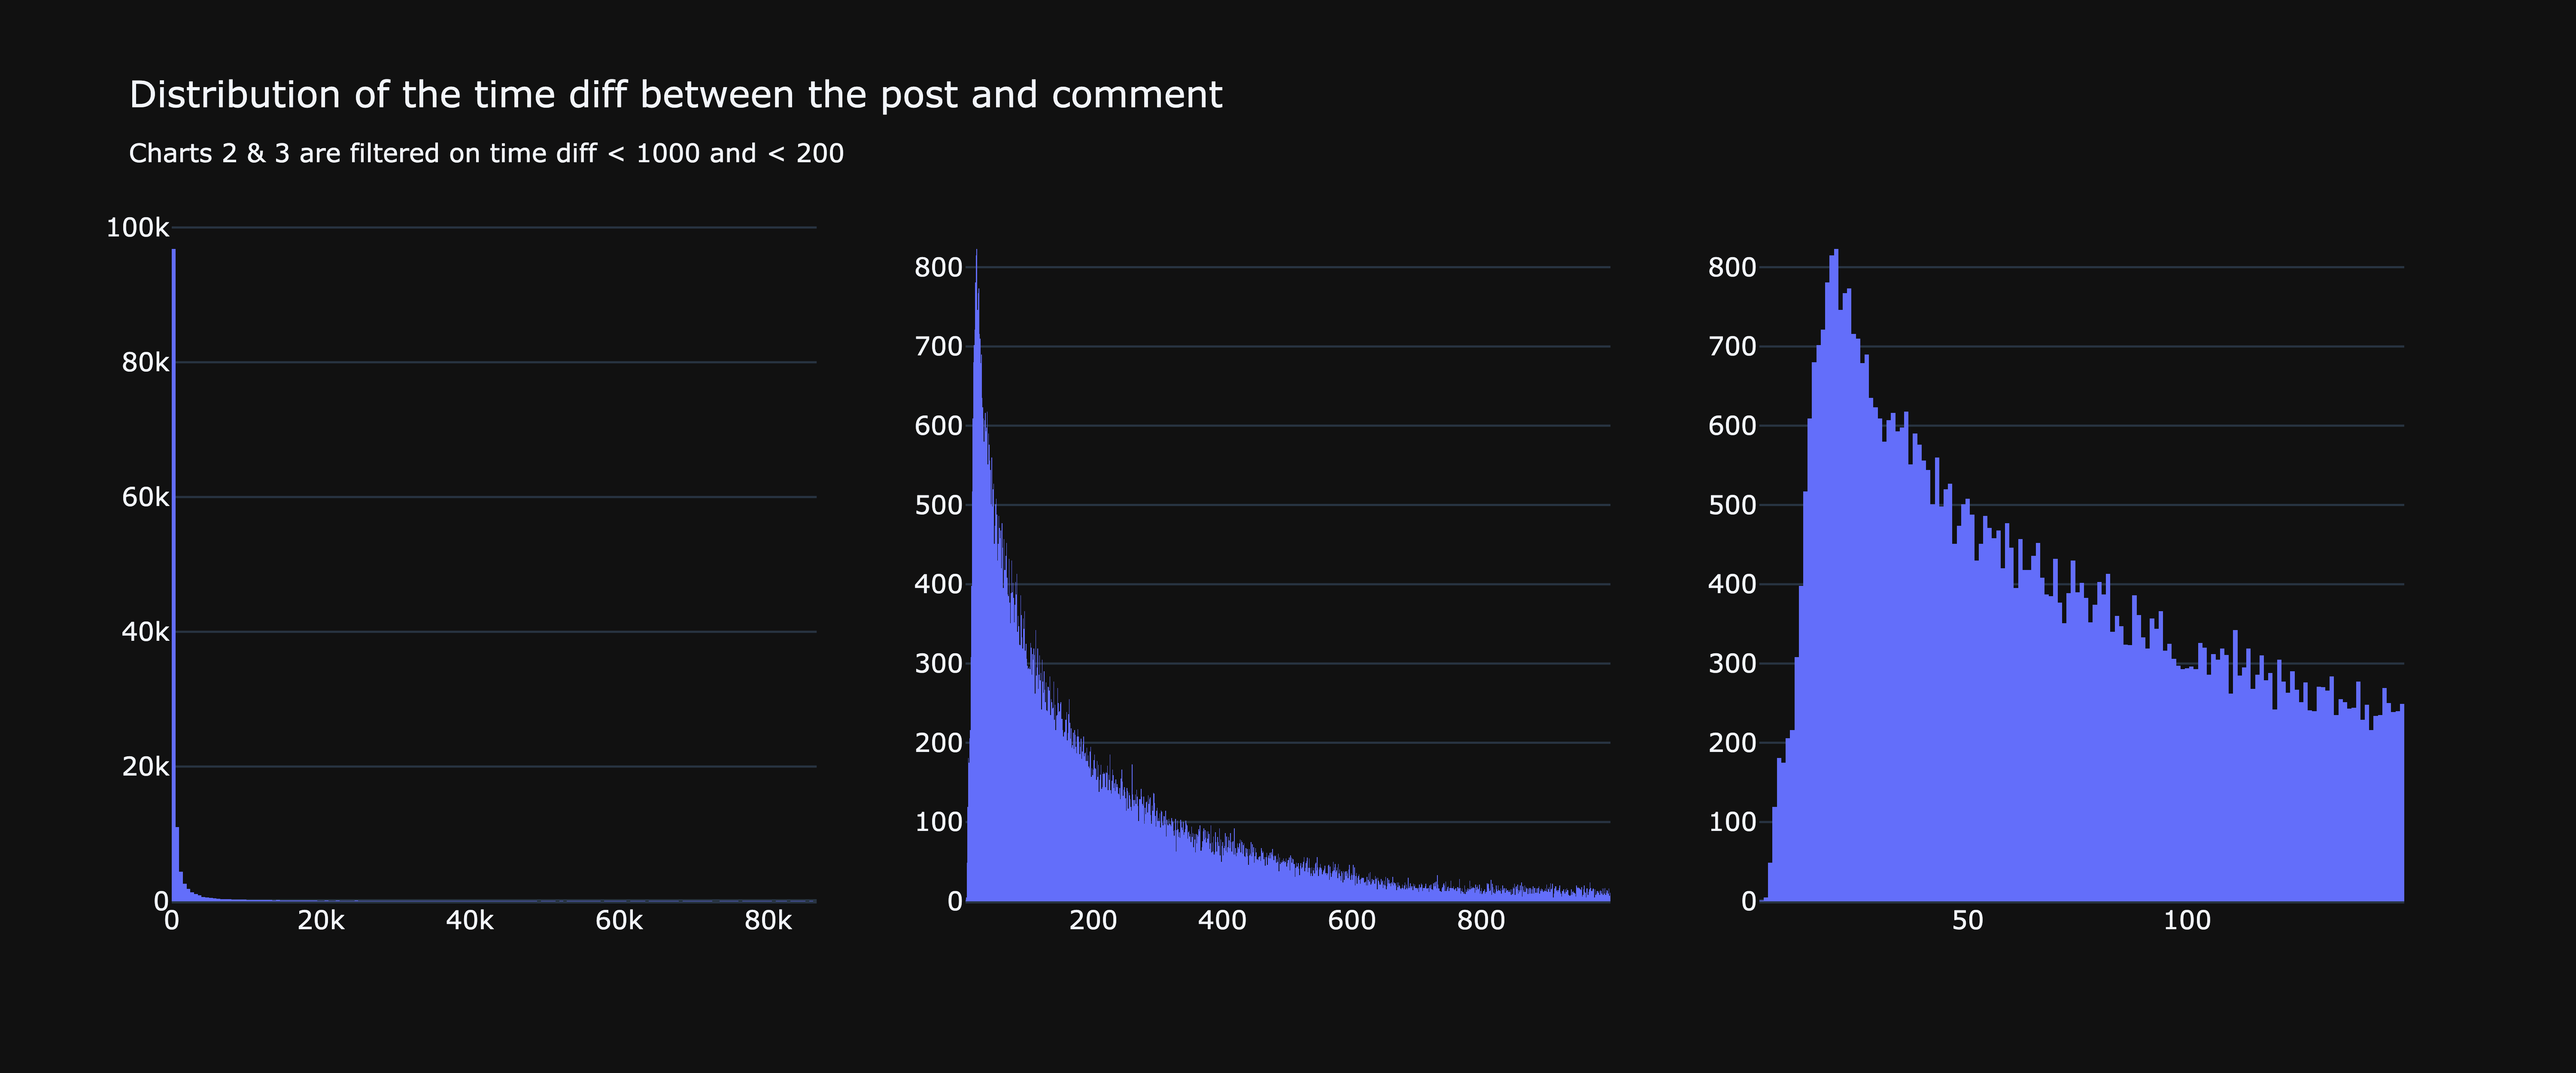

In [13]:
# Show distribution of the comments and the time difference
fig1 = px.histogram(df_comments, 
                    x = 'time_difference')
                    
fig2 = px.histogram(df_comments.query('time_difference < 1000'), 
                    x = 'time_difference', 
                    nbins = 1000)

fig3 = px.histogram(df_comments.query('time_difference < 150'), 
                    x = 'time_difference',
                    nbins=150)


# Join figures
fig_join = sv.join_plots([fig1, fig2, fig3],
                         title='Distribution of the time diff between the post and comment',
                         subtitle='Charts 2 & 3 are filtered on time diff < 1000 and < 200')

# Save chart
file_name = 'Distribution of the time diff between the post and comment - Dual Histogram lt 1000'
sv.save_plotly(fig_join, file_name, 'image')

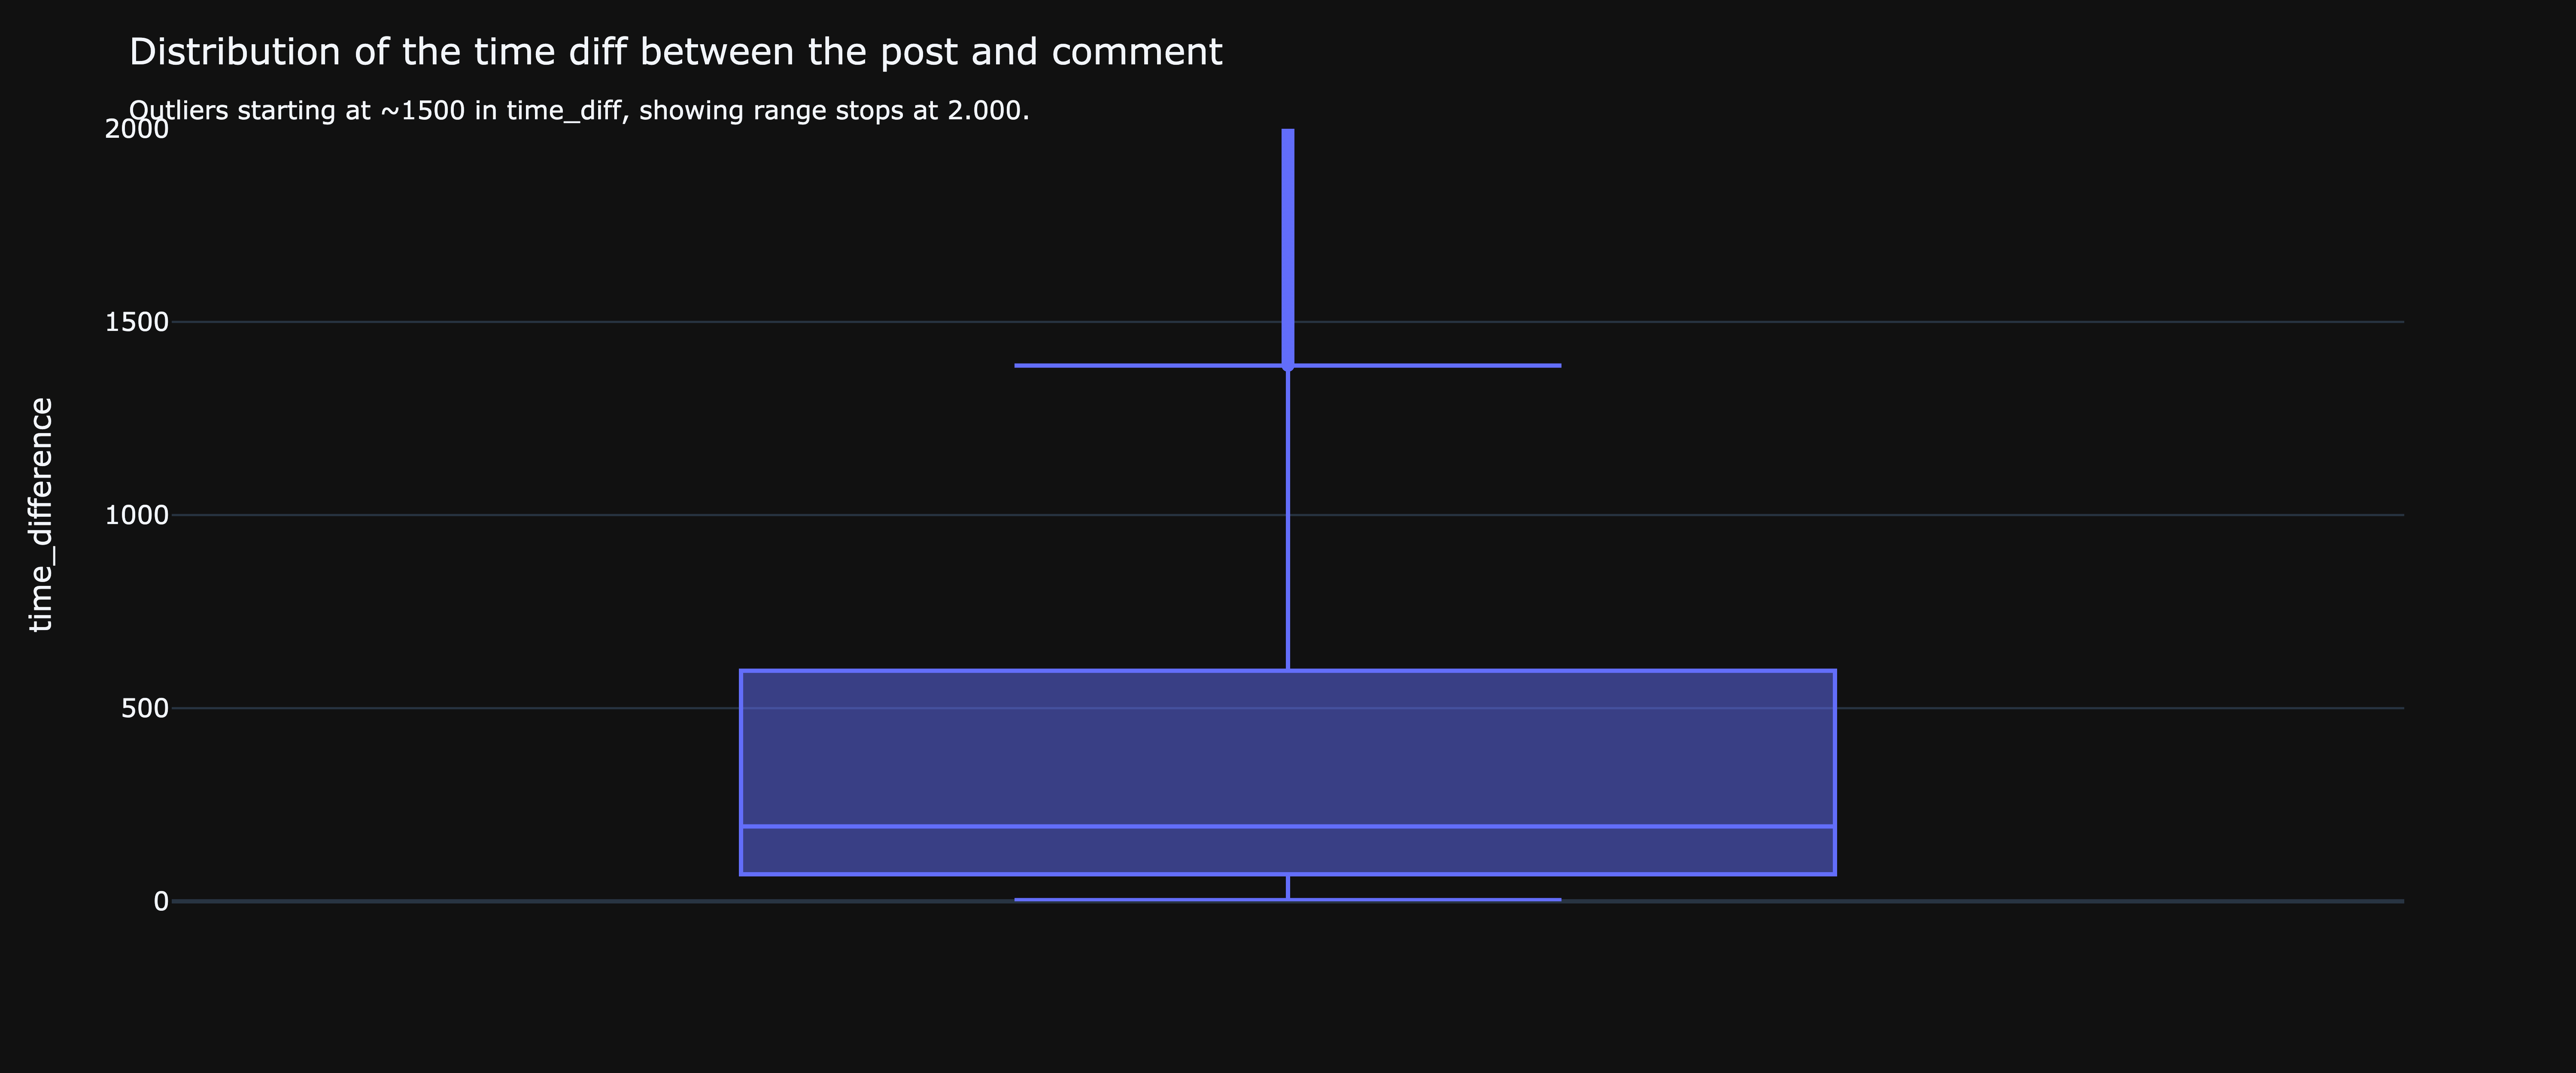

In [14]:
# Create box plot 
fig = px.box(df_comments, y="time_difference")
fig.update_layout(yaxis_range=(0, 2000), # Don't show the chart above 1000 seconds
                  title='Distribution of the time diff between the post and comment<br><sub>Outliers starting at ~1500 in time_diff, showing range stops at 2.000.')


# Save chart
file_name = 'Distribution of the time diff between the post and comment - Dual Histogram lt 500'
sv.save_plotly(fig, file_name, 'image')

For most of the comments collected, 75% have been posted in the first 10 minutes after the post has been posted. The median is a third of that, half of the comments were posted in the first three minutes. The peak of the most comments posted at the same time happends 19-20 seconds after the post is published. Once the users are labelled, it'll be interesting to see the difference in that 0-20 seconds window to see the ratio of bots compared to later. The data is not representative of all Instagram data as when collecting it, I was starting collecting the first IG was showing, the ones with the most likes.

### 1.5 Comment likes
The like columns is string containing the number of likes formated with thousand commas followed by 'Likes'. The column should be and ineger without any character being non numeric

In [15]:
print('With likes')
display(df_comments['comment_likes'].head())
print('Without likes')
df_comments.query('comment_likes.str.contains("like")==False')['comment_likes'].head()

With likes


0    2,234 likes
1    3,011 likes
2      967 likes
3    1,024 likes
4      966 likes
Name: comment_likes, dtype: object

Without likes


23     Reply
104    Reply
107    Reply
176    Reply
178    Reply
Name: comment_likes, dtype: object

In [16]:
# Replacing 'Reply' by '0' and then extracting all numbers from the strings
df_comments.loc[df_comments['comment_likes']=='Reply', 'comment_likes'] = '0'
df_comments['comment_likes'] = df_comments['comment_likes'].str.replace('\D+', '', regex=True).astype(int)
df_comments.query('username in @pages')

username                                            comment  \
8          bleacherreport                  Bucks are up 39 on the Warriors 😳   
180     houseofhighlights                                                  💯   
253                  slam                                📷: @atibaphotoReply   
1397                  nfl  Catch the full interview between @williemcgine...   
4409           brgridiron  How Jalen responded to this says a lot about h...   
...                   ...                                                ...   
129616         brgridiron                      Fitzmagic appreciation button   
130719     bleacherreport         Should Ja Morant be in the dunk contest? 👀   
131123           br_hoops                                     🎥 @noahxbarron   
131628                nba  Watch Dirk Nowitzki's Jersey Retirement Ceremo...   
133617                433                            Juventus 1️⃣➖1️⃣ Napoli   

        comment_likes            page  verified_user  time_difference  
8                2489  bleacherreport              1               54  
180               428  bleacherreport              1              405  
253                 1            slam              1              293  
1397              346      nflnetwork              1               65  
4409            17883  bleacherreport              1             1142  
...               ...             ...            ...              ...  
129616           4063      brgridiron              1              821  
130719           9453  bleacherreport              1              199  
131123              0        br_hoops              1               16  
131628            106             nba              1              509  
133617           1254             433              1               70  

[264 rows x 6 columns]

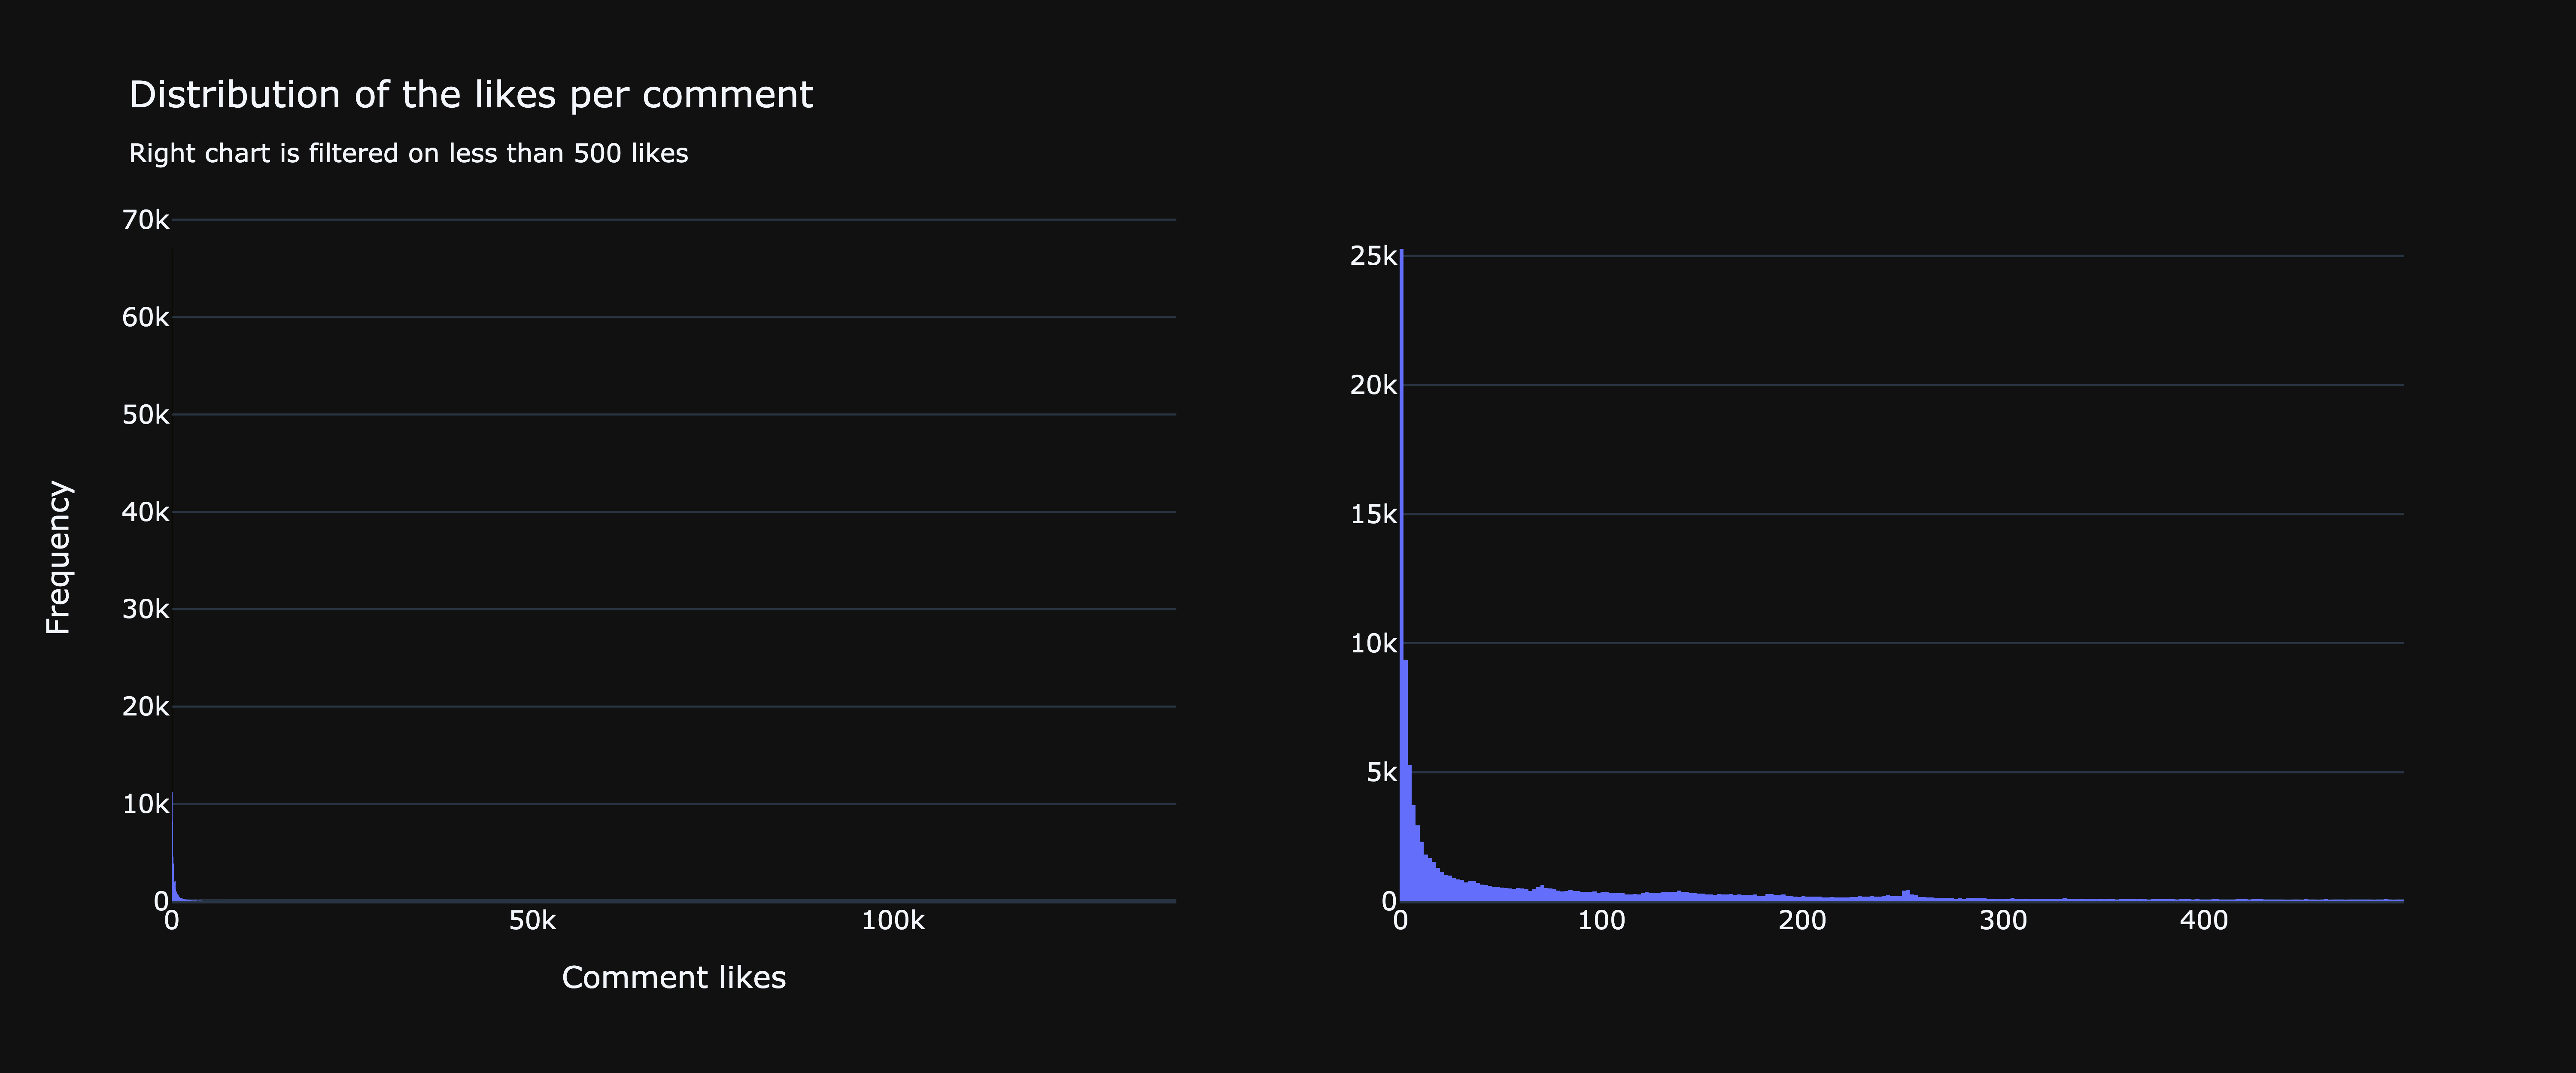

In [17]:
# Show distribution of the comments and the time difference
fig1 = px.histogram(df_comments, 
                    x = 'comment_likes')
                    
fig2 = px.histogram(df_comments.query('comment_likes < 500'), 
                    x = 'comment_likes', 
                    nbins = 400)


fig_join = sv.join_plots([fig1, fig2],
                         title='Distribution of the likes per comment',
                         subtitle='Right chart is filtered on less than 500 likes')

# Update axis names
fig_join.update_layout(xaxis_title="Comment likes",
                       yaxis_title="Frequency")

# Save chart
file_name = 'Distribution of the likes per comment - Dual Histogram lt 500'
sv.save_plotly(fig_join, file_name, 'image')

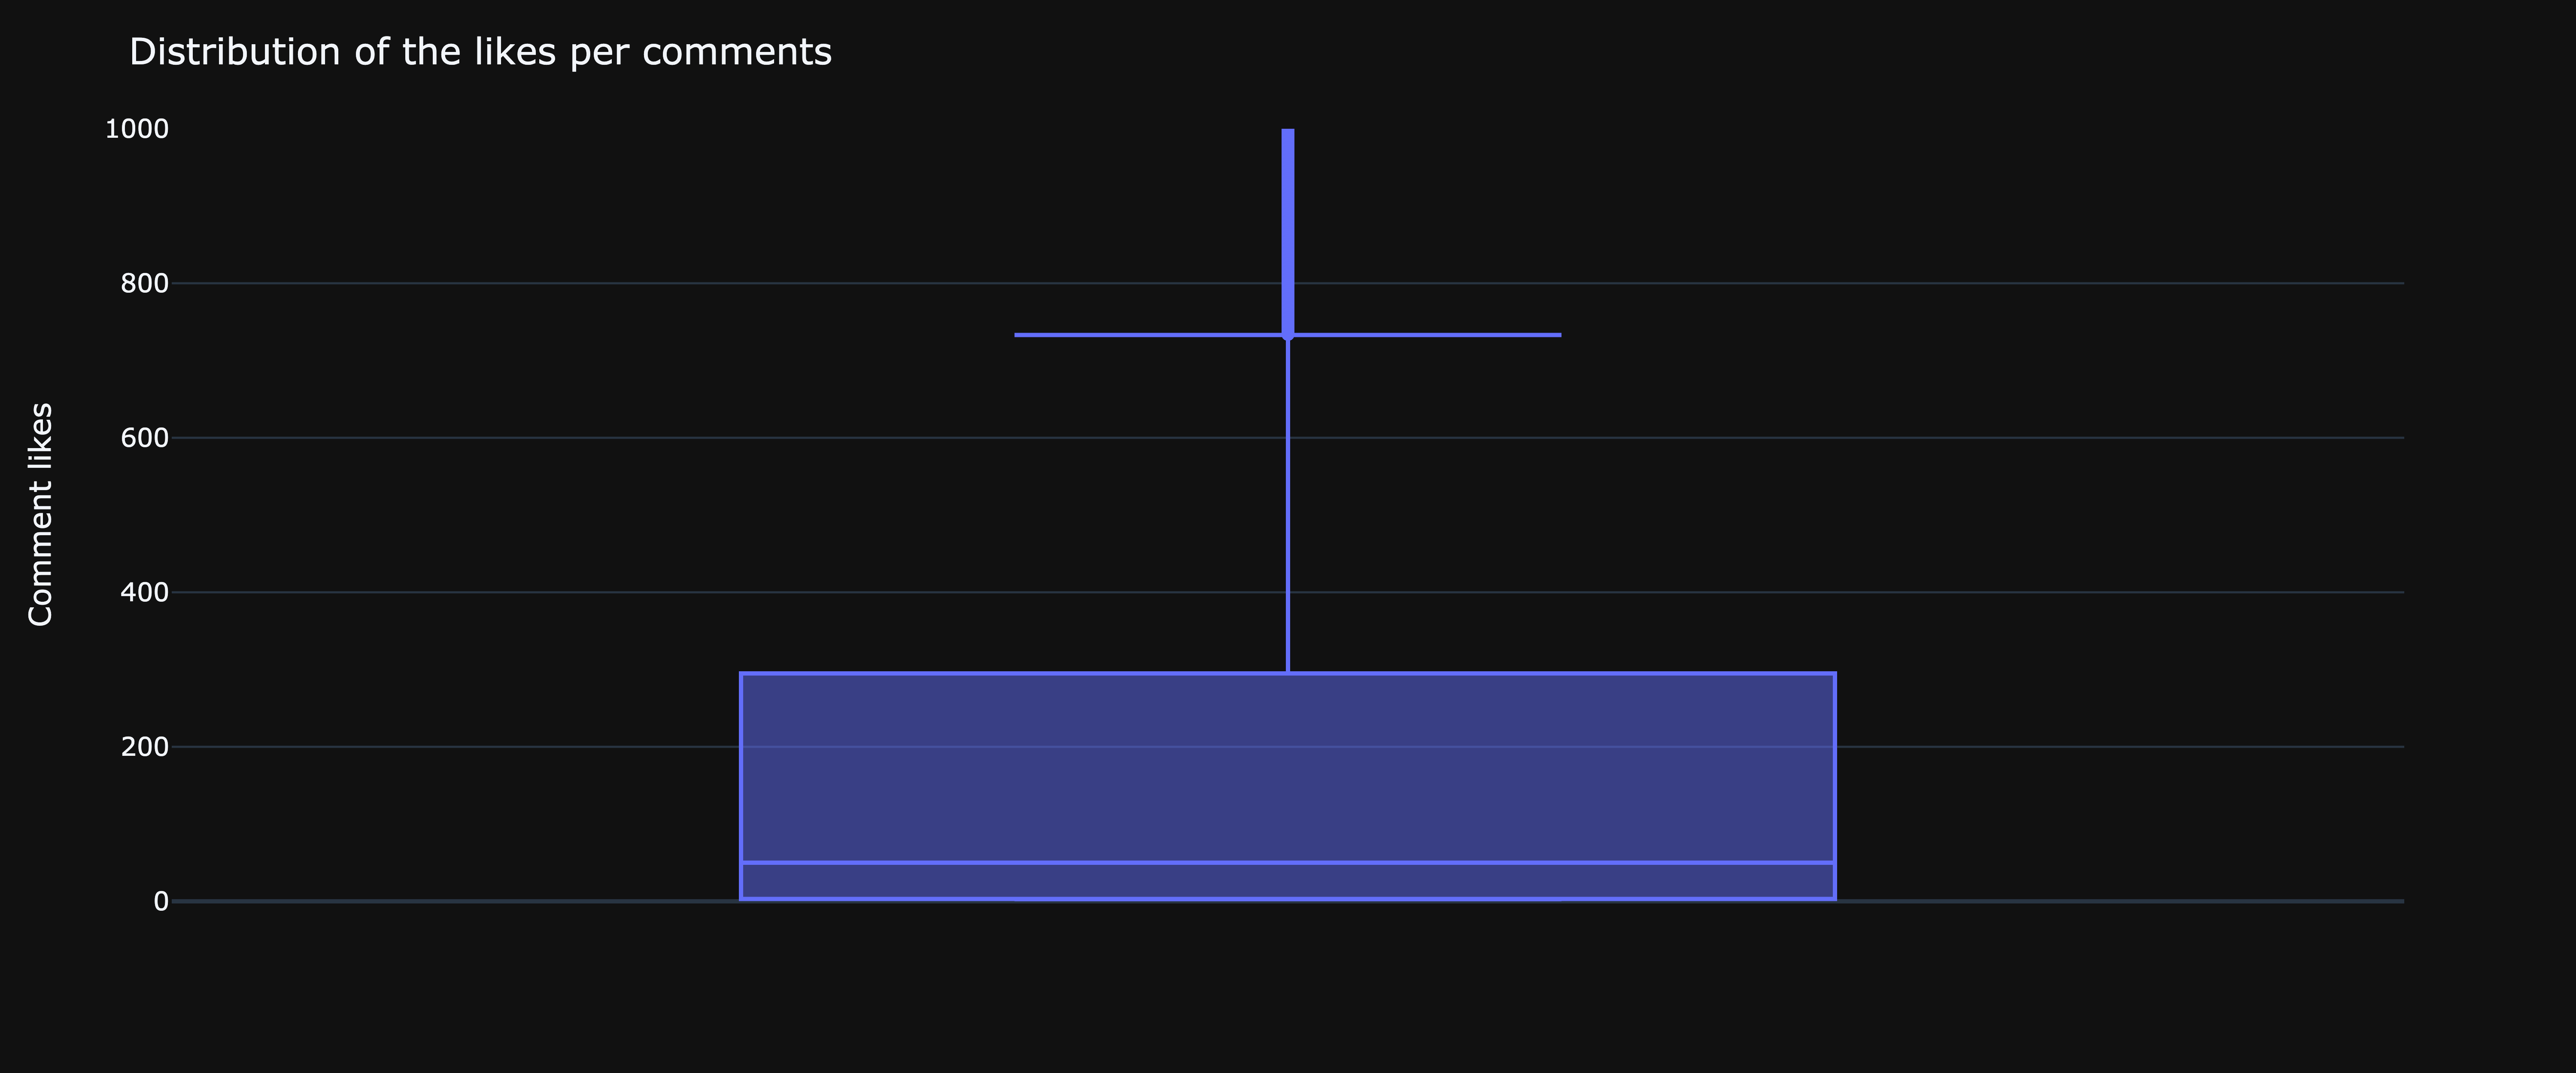

In [18]:
# Create box plot 
fig = px.box(df_comments, 
             y="comment_likes")

fig.update_layout(title='Distribution of the likes per comments', 
                  yaxis_range=(0, 1000), # Don't show the chart above 1000 seconds
                  yaxis_title="Comment likes") 


# Save chart
file_name = 'Distribution of the likes per comment - box plot'
sv.save_plotly(fig, file_name, 'image')

75% of the comments have less than 295 likes with half less than 50 likes. Let's look at the relationship with likes and how it varies depending on when the comment has been posted. 

In [19]:
# The user table is not yet clean but I can still get the follower count of all users
query = '''
select 
    distinct 
    username
    , edge_followed_by_count as follower_count
from users
'''

df_users_follow_count = pd.read_sql_query(query, con)

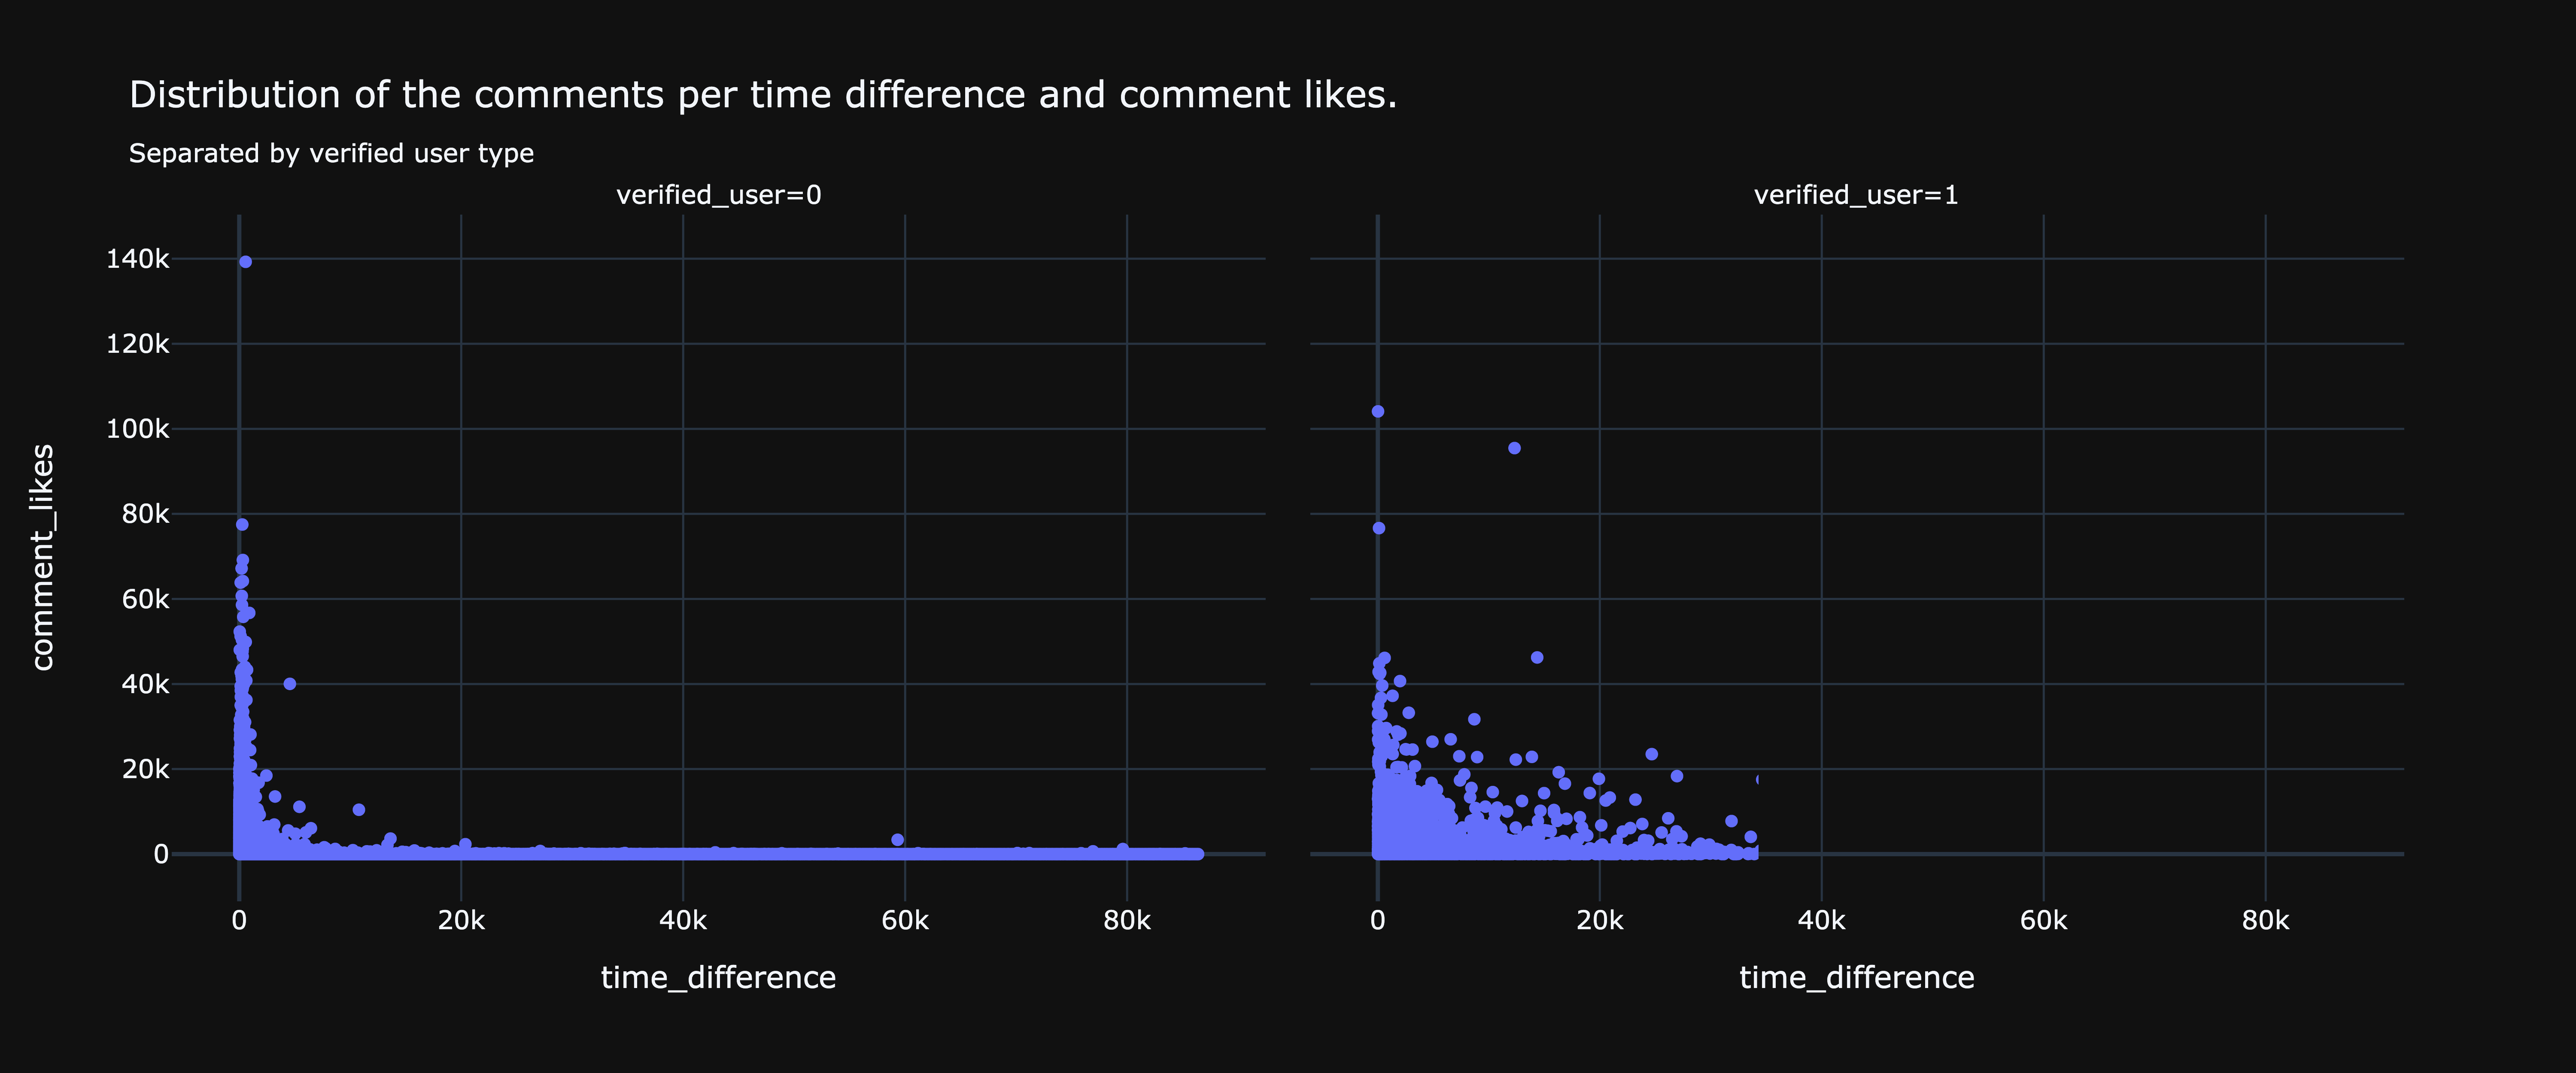

In [20]:
fig = px.scatter(df_comments, 
                 x='time_difference', 
                 y='comment_likes', 
                 facet_col='verified_user',
                 title = 'Distribution of the comments per time difference and comment likes.<br><sub>Separated by verified user type')


# Export
file_name = 'Time difference vs comment likes - Dual scatter verified users'
sv.save_plotly(fig, file_name, 'image')

There is a general trend, the more time after the post is posted you comment, the less likes you will have. This is because there are already a bunch of poeple that have seen the post before the late comment so less potential like count. Except in rare situations, this is always the case for non verified users, they always have low likes if they don't comment at the beginning. For verified users, it's not the same as they ahave their followers naturally liking their comment or the page owner commenting on its own post. It'll be interesting to see how the distribution changes for bots/legit users.

### 1.6 Comment content

* While scraping the comments, I also collect the button name right under and collected in some comments 'Hide replies' and 'Reply'.
* Many comments have emojis

In [21]:
df_comments.query('comment.str.contains("Hide replies|Reply") and username in @pages').head()

username                                            comment  \
253          slam                                📷: @atibaphotoReply   
12326  brgridiron  Enjoy watching him while we can. Watch his ent...   
12916        slam                                 🎥: @nbaonespnReply   
14672     espnnfl                       Man did a full plank 😮😂Reply   
15413    br_hoops  Final Score: Sierra Canyon 8️⃣3️⃣ Venice 4️⃣9️...   

       comment_likes        page  verified_user  time_difference  
253                1        slam              1              293  
12326            214  brgridiron              1              137  
12916              2        slam              1               25  
14672           2176        ESPN              1              167  
15413              2    br_hoops              1               78

In [22]:
# Removing hide replies and reply from the comment
df_comments["comment"] = df_comments["comment"].apply(lambda x: x[:-12] if x[-12:]=="Hide replies" else x)
df_comments["comment"] = df_comments["comment"].apply(lambda x: x[:-5] if x[-5:]=="Reply" else x)

In [23]:
df_comments.query('comment.str.contains("Hide replies|Reply")')

Empty DataFrame
Columns: [username, comment, comment_likes, page, verified_user, time_difference]
Index: []

In [24]:
# Adding a column with emoji count of the comments
df_comments["emoji_dict"] = df_comments["comment"].apply(lambda x: su.count_emoji(x))

# Adding the count of distinct emoji and the count of emojis in total
df_comments["emoji_count"] = df_comments["emoji_dict"].apply(lambda x: sum(x.values()))
df_comments["emoji_count_distinct"] = df_comments["emoji_dict"].apply(lambda x: len(x.keys()))

# Removing emoji from comments
df_comments["comment_wo_emoji"] = df_comments["comment"].apply(lambda x: demoji.replace(x, "").strip())

# # Adding a columns containing all emojis
df_comments["emoji"] = df_comments["emoji_dict"].apply(lambda x: ''.join(x.keys()))

df_comments.query('username in @pages').head()

username                                            comment  \
8        bleacherreport                  Bucks are up 39 on the Warriors 😳   
180   houseofhighlights                                                  💯   
253                slam                                     📷: @atibaphoto   
1397                nfl  Catch the full interview between @williemcgine...   
4409         brgridiron  How Jalen responded to this says a lot about h...   

      comment_likes            page  verified_user  time_difference  \
8              2489  bleacherreport              1               54   
180             428  bleacherreport              1              405   
253               1            slam              1              293   
1397            346      nflnetwork              1               65   
4409          17883  bleacherreport              1             1142   

     emoji_dict  emoji_count  emoji_count_distinct  \
8      {'😳': 1}            1                     1   
180    {'💯': 1}            1                     1   
253    {'📷': 1}            1                     1   
1397         {}            0                     0   
4409   {'💯': 1}            1                     1   

                                       comment_wo_emoji emoji  
8                       Bucks are up 39 on the Warriors     😳  
180                                                         💯  
253                                       : @atibaphoto     📷  
1397  Catch the full interview between @williemcgine...        
4409   How Jalen responded to this says a lot about him     💯

In [25]:
# Top 100 most used emojis
# Add all emojis to same string
all_emojis = ''

for emoji_dict in df_comments['emoji_dict']:
    for key, value in emoji_dict.items():
        for _ in range(value):
            all_emojis += key


# Sort all emojis to 
sorted_emojis = sorted({emoji: all_emojis.count(emoji) for emoji in set(all_emojis)}.items(), key=lambda x: x[1], reverse=True)

# Display top 100 emojis
rows = 5
cols = 20
lst = [['' for _ in range(rows)] for _ in range(cols)]

for index1 in range(cols):
    for index2 in range(rows):
        ind = index2 * cols + index1 + 1
        emoji, count = sorted_emojis[ind - 1]
        white_space = '\n' if index2 == 4 else '\t'
        lst[index1][index2] = f'{ind}: {emoji} - {count} {white_space}'

print('Top 100 most used emojis\n')
print(''.join([''.join(i) for i in lst]))

Top 100 most used emojis

1: 😂 - 24018 	21: 🙏 - 1192 	41: 😈 - 639 	61: ✨ - 321 	81: 🌸 - 221 
2: 🔥 - 16873 	22: 💪 - 1181 	42: 🤷 - 638 	62: 🇬 - 316 	82: 😔 - 220 
3: ️ - 10025 	23: 🤦 - 1088 	43: 👑 - 638 	63: 🔵 - 305 	83: 💫 - 215 
4: ❤ - 6374 	24: 🇦 - 1067 	44: 💰 - 589 	64: 💚 - 304 	84: 🇲 - 215 
5: 😭 - 4342 	25: 🇧 - 1063 	45: 😤 - 561 	65: ⚽ - 290 	85: 😐 - 212 
6: 👏 - 4285 	26: 😮 - 1021 	46: 🥺 - 502 	66: 👊 - 278 	86: 😏 - 210 
7: 😍 - 3960 	27: 🏻 - 929 	47: 👍 - 499 	67: 🌈 - 272 	87: 😒 - 203 
8: 🤣 - 3122 	28: 👀 - 869 	48: 🏿 - 458 	68: 🅿 - 269 	88: 🏈 - 201 
9: 💜 - 2825 	29: 🖤 - 867 	49: ✅ - 451 	69: 😎 - 269 	89: ❗ - 200 
10: 🙌 - 2353 	30: 🇸 - 854 	50: 🤍 - 440 	70: 🇩 - 268 	90: 👌 - 199 
11: ‍ - 2237 	31: 💋 - 819 	51: 🇹 - 425 	71: 🙄 - 268 	91: ⭐ - 197 
12: 💀 - 2182 	32: 🇨 - 789 	52: ⚡ - 422 	72: ☠ - 260 	92: 🍇 - 197 
13: 💙 - 2166 	33: 🤡 - 782 	53: 🤔 - 419 	73: 💸 - 251 	93: 🥱 - 194 
14: 🏾 - 1942 	34: 🏼 - 758 	54: 😅 - 415 	74: 🤩 - 250 	94: 🇿 - 194 
15: 🇷 - 1939 	35: 🇺 - 738 	55: 😩 - 405 	75: 🍀 - 24

### 1.7 Export data

In [26]:
df_comments['emoji_dict'] = df_comments['emoji_dict'].apply(str)
df_comments.to_sql('clean_comments', con, if_exists='replace')

134465

## 2. Last 12 posts

This is the table containing all the information about the last 12 posts of the users. 12 is not chosen but the number of posts automatically sent back by Instagram when looking a user profile. Each row is a post of a user. 


### 2.1 Load data and quick expolore

In [27]:
query = '''
select 
    * 
from last_12_posts
'''

df_last12 = pd.read_sql_query(query, con)
df_last12.query('username in @pages').head()

username  video_views  \
59449   pubity     285266.0   
59450   pubity          NaN   
59451   pubity          NaN   
59452   pubity    3127494.0   
59453   pubity    5009973.0   

                                             display_url  \
59449  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59450  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59451  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59452  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59453  https://scontent-lga3-2.cdninstagram.com/v/t51...   

                                           thumbnail_src  \
59449  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59450  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59451  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59452  https://scontent-lga3-2.cdninstagram.com/v/t51...   
59453  https://scontent-lga3-2.cdninstagram.com/v/t51...   

                                   accessibility_caption is_video     likes  \
59449                                               None        1   55245.0   
59450  Photo by Pubity on January 18, 2022. May be an...        0  120712.0   
59451  Photo by Pubity on January 18, 2022. May be an...        0  242937.0   
59452                                               None        1  485572.0   
59453                                               None        1  456726.0   

       comments     timestamp  
59449     283.0  1.642585e+09  
59450     569.0  1.642577e+09  
59451     734.0  1.642574e+09  
59452    2587.0  1.642553e+09  
59453    3602.0  1.642548e+09

In [28]:
df_last12.describe(include='all').round()

username  video_views  \
count         363408      66420.0   
unique         40638          NaN   
top     bertilenasso          NaN   
freq              24          NaN   
mean             NaN       8438.0   
std              NaN     197168.0   
min              NaN          0.0   
25%              NaN        121.0   
50%              NaN        381.0   
75%              NaN       1471.0   
max              NaN   29283666.0   

                                              display_url  \
count                                              363408   
unique                                             363394   
top     https://scontent-lga3-1.cdninstagram.com/v/t51...   
freq                                                    2   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                            thumbnail_src  \
count                                              363408   
unique                                             363392   
top     https://scontent-lga3-1.cdninstagram.com/v/t51...   
freq                                                    2   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    accessibility_caption is_video      likes  \
count                                              288358   363408   363408.0   
unique                                             275410        2        NaN   
top     Photo by Anabelle on January 15, 2022. May be ...        0        NaN   
freq                                                   23   296988        NaN   
mean                                                  NaN      NaN      419.0   
std                                                   NaN      NaN     6501.0   
min                                                   NaN      NaN        0.0   
25%                                                   NaN      NaN       26.0   
50%                                                   NaN      NaN       74.0   
75%                                                   NaN      NaN      189.0   
max                                                   NaN      NaN  2331247.0   

        comments     timestamp  
count   363408.0  3.634080e+05  
unique       NaN           NaN  
top          NaN           NaN  
freq         NaN           NaN  
mean        17.0  1.621347e+09  
std         76.0  3.182074e+07  
min          0.0  1.334434e+09  
25%          1.0  1.616687e+09  
50%          4.0  1.634504e+09  
75%         14.0  1.640617e+09  
max      15354.0  1.644333e+09

In [29]:
df_last12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363408 entries, 0 to 363407
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   username               363408 non-null  object 
 1   video_views            66420 non-null   float64
 2   display_url            363408 non-null  object 
 3   thumbnail_src          363408 non-null  object 
 4   accessibility_caption  288358 non-null  object 
 5   is_video               363408 non-null  object 
 6   likes                  363408 non-null  float64
 7   comments               363408 non-null  float64
 8   timestamp              363408 non-null  float64
dtypes: float64(4), object(5)
memory usage: 25.0+ MB


In [30]:
df_last12.isna().sum()

username                      0
video_views              296988
display_url                   0
thumbnail_src                 0
accessibility_caption     75050
is_video                      0
likes                         0
comments                      0
timestamp                     0
dtype: int64

Couple of insights from that: 
* Missing values in video views but this is likely due to photos posts
* About 75k missing captions and 300k video views. Those are maybe due to posts being photos and just no caption
* Most of the columns have the wrong datatypes (float instead of int, object for date)


### 2.2 Removing irrelevant columns and renaming some

In [31]:
# Renaming some columns
df_last12 = df_last12.rename({"timestamp": "posted_time",
                              'accessibility_caption': 'caption'}, axis=1)

# Removing and reordering columns
df_last12 = df_last12.drop(['display_url', 'thumbnail_src'], axis=1)
df_last12 = df_last12[["username", "likes", "is_video", "video_views", "comments", "caption", "posted_time"]]

df_last12.query('username in @pages').head()

username     likes is_video  video_views  comments  \
59449   pubity   55245.0        1     285266.0     283.0   
59450   pubity  120712.0        0          NaN     569.0   
59451   pubity  242937.0        0          NaN     734.0   
59452   pubity  485572.0        1    3127494.0    2587.0   
59453   pubity  456726.0        1    5009973.0    3602.0   

                                                 caption   posted_time  
59449                                               None  1.642585e+09  
59450  Photo by Pubity on January 18, 2022. May be an...  1.642577e+09  
59451  Photo by Pubity on January 18, 2022. May be an...  1.642574e+09  
59452                                               None  1.642553e+09  
59453                                               None  1.642548e+09

### 2.3 Videos 

Checking for missing values and changing types

In [32]:
# Changing the type of is_video
df_last12['is_video'] = df_last12['is_video'].astype(int)

ratio = df_last12['is_video'].sum() / df_last12.shape[0]
print(f'Ratio to videos for all posts: {round(ratio, 2)}')

Ratio to videos for all posts: 0.18


In [33]:
# Looking at missing values for post being is video and is not
df_last12['video_views'].isna().sum()
for x in (0, 1):
    print(x, df_last12.query(f'is_video == {x}')['video_views'].isna().sum())

0 296988
1 0


In [34]:
# Replacing missing video views by 0
df_last12['video_views'] = df_last12['video_views'].fillna(0).astype(int)

Missing values are only for when the post is a video. Knowing there is the `is_video` flag in another column, I can fill the missing values by 0

In [35]:
# By removing the top 1% of the data, it's easier to see the distribution of the video views
percent99 = df_last12.query('is_video == 1')['video_views'].quantile(0.99)
print(f'{percent99 = :,.0f}')

fig_percent99 = px.histogram(df_last12.query('video_views < @percent99 and is_video == 1'), 
                             x='video_views', 
                             nbins=1000)
                             
fig_percent99.update_layout(xaxis_range=(0, percent99))



percent99 = 112,571


### 2.4 Caption extraction

The caption contains the caption, date, people tagged but I won't do NLP and I have the timestamp so date so I'm only keeping if/how many accounts are tagged

In [36]:
# Counting tagged people and removing the column 
df_last12['tagg_count'] = df_last12['caption'].str.count('@').fillna(0).astype(int)
df_last12 = df_last12.drop('caption', axis=1)
df_last12.query('username in @pages').head()

username     likes  is_video  video_views  comments   posted_time  \
59449   pubity   55245.0         1       285266     283.0  1.642585e+09   
59450   pubity  120712.0         0            0     569.0  1.642577e+09   
59451   pubity  242937.0         0            0     734.0  1.642574e+09   
59452   pubity  485572.0         1      3127494    2587.0  1.642553e+09   
59453   pubity  456726.0         1      5009973    3602.0  1.642548e+09   

       tagg_count  
59449           0  
59450           0  
59451           0  
59452           0  
59453           0

### 2.5 Timestamp

The timestamp is when the post has been posted

In [37]:
df_last12['posted_time'] = pd.to_datetime(df_last12['posted_time'], unit='s')
df_last12.query('username in @pages').head()

username     likes  is_video  video_views  comments         posted_time  \
59449   pubity   55245.0         1       285266     283.0 2022-01-19 09:36:16   
59450   pubity  120712.0         0            0     569.0 2022-01-19 07:27:57   
59451   pubity  242937.0         0            0     734.0 2022-01-19 06:32:33   
59452   pubity  485572.0         1      3127494    2587.0 2022-01-19 00:44:22   
59453   pubity  456726.0         1      5009973    3602.0 2022-01-18 23:19:10   

       tagg_count  
59449           0  
59450           0  
59451           0  
59452           0  
59453           0

### 2.6 Export table

In [38]:
df_last12.to_sql('clean_last12', con, if_exists='replace')

363408

##  3. User Profile Data

User profile data is all the information on the user, each row is a single user, not like the precedent table.

### 3.1 Load data and quick expolore

In [39]:
query = '''
select 
    * 
from users
'''

df_users = pd.read_sql_query(query, con)
df_users.query('username in @pages' ).head()

biography blocked_by_viewer  \
14232  ☀️ Lifestyle\n💫 Culture\n📧 contact - pubitycon...                 0   
56114  Follow to join the movement 👥\n📧 hi@meme.media...                 0   

      restricted_by_viewer country_block              external_url  \
14232                 None             0                      None   
56114                 None             0  https://linktr.ee/Memeig   

                                external_url_linkshimmed  \
14232                                               None   
56114  https://l.instagram.com/?u=https%3A%2F%2Flinkt...   

       edge_followed_by_count               fbid followed_by_viewer  \
14232                30442605  17841401345492370                  0   
56114                10777403  17841401661947859                  0   

       edge_follow_count follows_viewer       full_name has_ar_effects  \
14232               2055              0          Pubity              0   
56114                320              0  MEMES | COMEDY              0   

      has_clips has_guides has_channel has_blocked_viewer  \
14232         1          0           0                  0   
56114         1          0           0                  0   

       highlight_reel_count has_requested_viewer hide_like_and_view_counts  \
14232                     4                    0                         0   
56114                     0                    0                         1   

               id is_business_account is_professional_account  \
14232  1431724849                   1                       1   
56114   503031398                   1                       1   

      is_embeds_disabled is_joined_recently business_address_json  \
14232                  0                  0                  None   
56114                  0                  0                  None   

      business_contact_method business_email business_phone_number  \
14232                    None           None                  None   
56114                    None           None                  None   

                      business_category_name overall_category_name  \
14232  Non-Profits & Religious Organizations                  None   
56114                       General Interest                  None   

      category_enum category_name is_private is_verified  \
14232          None     Community          0           0   
56114          None         Media          0           0   

       edge_mutual_followed_by_count edge_mutual_followed_by_edges  \
14232                              0                                 
56114                              0                                 

                                         profile_pic_url  \
14232  https://scontent-lga3-2.cdninstagram.com/v/t51...   
56114  https://scontent-lga3-2.cdninstagram.com/v/t51...   

                                      profile_pic_url_hd requested_by_viewer  \
14232  https://scontent-lga3-2.cdninstagram.com/v/t51...                   0   
56114  https://scontent-lga3-2.cdninstagram.com/v/t51...                   0   

      should_show_category should_show_public_contacts username  \
14232                    0                           0   pubity   
56114                    0                           0  meme.ig   

      connected_fb_page pronouns  video_count  post_count pronouns_0  \
14232              None                   488       13589       None   
56114              None                   131        3204       None   

      pronouns_1 pronouns_2 pronouns_3 bio_links  \
14232       None       None       None      None   
56114       None       None       None      None   

      biography_with_entities_raw_text biography_with_entities_entities  \
14232                             None                             None   
56114                             None                             None   

      group_metadata  is_eligible_to_view_account_transparency  \
14232           None                                    

In [40]:
# Quick data summary 
df_users.describe(include='all').round()

biography blocked_by_viewer restricted_by_viewer country_block  \
count      86343             86343                    0         86343   
unique     67705                 1                    0             1   
top                              0                  NaN             0   
freq       16081             86343                  NaN         86343   
mean         NaN               NaN                  NaN           NaN   
std          NaN               NaN                  NaN           NaN   
min          NaN               NaN                  NaN           NaN   
25%          NaN               NaN                  NaN           NaN   
50%          NaN               NaN                  NaN           NaN   
75%          NaN               NaN                  NaN           NaN   
max          NaN               NaN                  NaN           NaN   

             external_url                           external_url_linkshimmed  \
count               19166                                              19166   
unique              18392                                              19166   
top     http://gmail.com/  https://l.instagram.com/?u=https%3A%2F%2Fonlyf...   
freq                   97                                                  1   
mean                  NaN                                                NaN   
std                   NaN                                                NaN   
min                   NaN                                                NaN   
25%                   NaN                                                NaN   
50%                   NaN                                                NaN   
75%                   NaN                                                NaN   
max                   NaN                                                NaN   

        edge_followed_by_count               fbid followed_by_viewer  \
count                  86343.0              86343              86343   
unique                     NaN              86304                  1   
top                        NaN  17841413368757747                  0   
freq                       NaN                  3              86343   
mean                    3765.0                NaN                NaN   
std                   119086.0                NaN                NaN   
min                        0.0                NaN                NaN   
25%                      263.0                NaN                NaN   
50%                      590.0                NaN                NaN   
75%                     1214.0                NaN                NaN   
max                 30442605.0                NaN                NaN   

        edge_follow_count follows_viewer full_name has_ar_effects has_clips  \
count             86343.0          86343     86343          86343     86343   
unique                NaN              1     69191              1         2   
top                   NaN              0                        0         0   
freq                  NaN          86343      9987          86343     70876   
mean                993.0            NaN       NaN            NaN       NaN   
std                1152.0            NaN       NaN            NaN       NaN   
min                   0.0            NaN       NaN            NaN       NaN   
25%                 328.0            NaN       NaN            NaN       NaN   
50%                 656.0            NaN       NaN            NaN       NaN   
75%                1155.0            NaN       NaN            NaN       NaN   
max                7509.0            NaN       NaN            NaN       NaN   

       has_guides has_channel has_blocked_viewer  highlight_reel_count  \
count       86343       86343              86343               86343.0   
unique          2           1                  1                   NaN   
top             0           0                  0                   NaN   
freq        86019       86343              86343           

In [41]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86343 entries, 0 to 86342
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   biography                                 86343 non-null  object 
 1   blocked_by_viewer                         86343 non-null  object 
 2   restricted_by_viewer                      0 non-null      object 
 3   country_block                             86343 non-null  object 
 4   external_url                              19166 non-null  object 
 5   external_url_linkshimmed                  19166 non-null  object 
 6   edge_followed_by_count                    86343 non-null  int64  
 7   fbid                                      86343 non-null  object 
 8   followed_by_viewer                        86343 non-null  object 
 9   edge_follow_count                         86343 non-null  int64  
 10  follows_viewer                    

In [42]:
df_users['post_count'].max()
df_users.query('post_count == 28728400')

biography blocked_by_viewer  \
2420  If you’re wondering what those 28 million post...                 0   

     restricted_by_viewer country_block external_url external_url_linkshimmed  \
2420                 None             0         None                     None   

      edge_followed_by_count               fbid followed_by_viewer  \
2420                   77177  17841411941659337                  0   

      edge_follow_count follows_viewer full_name has_ar_effects has_clips  \
2420               1496              0     Memes              0         0   

     has_guides has_channel has_blocked_viewer  highlight_reel_count  \
2420          0           0                  0                     0   

     has_requested_viewer hide_like_and_view_counts           id  \
2420                    0                         0  11834702055   

     is_business_account is_professional_account is_embeds_disabled  \
2420                   0                       0                  0   

     is_joined_recently business_address_json business_contact_method  \
2420                  0                  None                    None   

     business_email business_phone_number business_category_name  \
2420           None                  None                   None   

     overall_category_name category_enum category_name is_private is_verified  \
2420                  None          None          None          1           0   

      edge_mutual_followed_by_count edge_mutual_followed_by_edges  \
2420                              0                                 

                                        profile_pic_url  \
2420  https://scontent-lga3-1.cdninstagram.com/v/t51...   

                                     profile_pic_url_hd requested_by_viewer  \
2420  https://scontent-lga3-1.cdninstagram.com/v/t51...                   0   

     should_show_category should_show_public_contacts username  \
2420                    0                           0  moapies   

     connected_fb_page pronouns  video_count  post_count pronouns_0  \
2420              None                     1    28728400       None   

     pronouns_1 pronouns_2 pronouns_3 bio_links  \
2420       None       None       None      None   

     biography_with_entities_raw_text biography_with_entities_entities  \
2420                             None                             None   

     group_metadata  is_eligible_to_view_account_transparency  \
2420           None                                       NaN   

      is_supervision_enabled  is_guardian_of_viewer  is_supervised_by_viewer  \
2420                     NaN                    NaN                      NaN   

      is_supervised_user guardian_id state_controlled_media_country  \
2420                 NaN        None                           None   

     location_transparency_country transparency_label transparency_product  
2420                          None               None                 None

In [43]:
# for column in df_users: 
#     if 'pronouns' in column: 
#         print (column)
#         display(df_users[column].value_counts().to_frame())
df_users[['username', 'pronouns', 'pronouns_0', 'pronouns_1', 'pronouns_2', 'pronouns_3']].query('pronouns.notna() or pronouns != ""')

username pronouns pronouns_0 pronouns_1 pronouns_2 pronouns_3
0                jdog.d6                None       None       None       None
1            the.tjsmith                None       None       None       None
2                ginom79                None       None       None       None
3         brohltal.memes                None       None       None       None
4        chris_howard_22                None       None       None       None
...                  ...      ...        ...        ...        ...        ...
86338       nicklong7054                None       None       None       None
86339    blessedchild723                None       None       None       None
86340  iamboxingofficial                None       None       None       None
86341       takeajaytrip                None       None       None       None
86342       takeajaytrip                None       None       None       None

[86343 rows x 6 columns]

Many columns are not useful to the rest of the analysis, some other have no meaning so we'll remove them

* Most of the columns have no mising values
* The columns 'is_xxx' and 'xxx_count' have wrong data types, they should be integers
* There are five pronouns columns with all different count of missing values
* The business and professional columns don't have the same count of missing values which is odd as I was imaginating that business attributes are for all busienss account
* The last 9 columns have only two non missing values. the user has 'STATE_CONTROLLED_MEDIA' for transparancy_product
* external_url_linkshimmed: Instagram redirect, useless as eternal_url is already there
* fbid & id: facebook/IG id, not relevant
* profile_pic_url and profile_pic_url_hd: not relevant, photos already downloaded


### 3.2 Renaming and removing columns: 


In [44]:
# Removing constant columns and columns with 100% missing values
for column in df_users.columns:
    values = df_users[column].unique()
    na = df_users[column].isna().sum()

    # Removing N/As == 100%
    if na / df_users.shape[0] == 1: 
        df_users = df_users.drop(column, axis=1)
        print(f"NA - {column} removed, missing values: {na} - {na/df_users.shape[0]:.1%}")
        continue

    # Removing constants
    if len(values) == 1:
        df_users = df_users.drop(column, axis=1)
        print(f"C - {column} removed, constant: {values[0]}")

C - blocked_by_viewer removed, constant: 0
NA - restricted_by_viewer removed, missing values: 86343 - 100.0%
C - country_block removed, constant: 0
C - followed_by_viewer removed, constant: 0
C - follows_viewer removed, constant: 0
C - has_ar_effects removed, constant: 0
C - has_channel removed, constant: 0
C - has_blocked_viewer removed, constant: 0
C - has_requested_viewer removed, constant: 0
NA - business_address_json removed, missing values: 86343 - 100.0%
NA - business_email removed, missing values: 86343 - 100.0%
NA - business_phone_number removed, missing values: 86343 - 100.0%
NA - overall_category_name removed, missing values: 86343 - 100.0%
C - edge_mutual_followed_by_count removed, constant: 0
C - edge_mutual_followed_by_edges removed, constant: 
C - requested_by_viewer removed, constant: 0
NA - connected_fb_page removed, missing values: 86343 - 100.0%
NA - group_metadata removed, missing values: 86343 - 100.0%
NA - guardian_id removed, missing values: 86343 - 100.0%
NA - s

In [45]:
# Useless columns
cols_to_remove = ['external_url_linkshimmed', 'bio_links', 'biography_with_entities_raw_text', 'biography_with_entities_entities', 
                  'is_eligible_to_view_account_transparency', 'is_supervision_enabled', 'is_guardian_of_viewer', 'is_supervised_by_viewer', 
                  'is_supervised_user', 'transparency_product', 'profile_pic_url_hd', 'profile_pic_url', 'id', 'fbid']
 
for col in cols_to_remove: 
    df_users = df_users.drop(col, axis=1)


# Rename columns 
df_users = df_users.rename({'edge_followed_by_count': 'follower_count',
                            'edge_follow_count': 'follow_count'}, axis=1)

### 3.3 External url

Keeping only the domain

In [46]:
# Getting the domain of the url and removing external url
df_users['domain'] = df_users["external_url"].apply(lambda x: urlparse(x).netloc.replace('www.', '') if x != None else x)
df_users = df_users.drop('external_url', axis=1)

df_users['domain'].value_counts().head(30)

youtu.be                      2105
linktr.ee                     1978
youtube.com                   1172
bit.ly                         926
linkr.bio                      846
open.spotify.com               363
twitch.tv                      361
m.youtube.com                  357
twitter.com                    347
hudl.com                       328
soundcloud.app.goo.gl          273
music.apple.com                254
socprofile.com                 253
vsco.co                        233
facebook.com                   215
vm.tiktok.com                  210
soundcloud.com                 185
tellonym.me                    167
gofund.me                      148
instagram.com                  147
t.me                           124
cutt.ly                        111
gmail.com                      103
distrokid.com                   91
gofundme.com                    83
unitedmasters.com               68
discord.gg                      67
wa.me                           63
jw.org              

### 3.4 Pronouns

Multiple columns are named pronouns but don't have the same number of values in each. The goal is to consolidate the columns into one.

In [47]:
df_users['pronouns'].value_counts()

    83684
Name: pronouns, dtype: int64

The pronouns columns is useless as it has no information except missing values and empty strings

In [48]:
pronouns_columns = ['pronouns_0', 'pronouns_1', 'pronouns_2', 'pronouns_3']

# Concating all the columns into one
df_users['pronouns'] = df_users[pronouns_columns].apply(lambda x: ', '.join(sorted([x[col] for col in pronouns_columns if pd.notna(x[col])])), axis=1)
df_users.loc[df_users['pronouns'].ne(''), 'pronouns'].head(15)

13                him
140               him
141          her, she
145               him
192               him
193           he, him
195           he, him
208           he, him
282          he, they
302    her, hers, she
328      he, him, his
353           he, him
370               him
425         she, they
517           he, him
Name: pronouns, dtype: object

In [49]:
# All pronouns distribution
pd.concat([pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(), 
pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(normalize=True).round(2)], axis=1)

pronouns_valcount = pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts().round(2)
pronouns_valcount_normalized = pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(normalize=True).round(2)

# Removing pronouns columns
df_users = df_users.drop(pronouns_columns, axis=1)

print('Distribution of the pronoumns and the normalized value')
pd.concat([pronouns_valcount, pronouns_valcount_normalized], axis=1)

Distribution of the pronoumns and the normalized value


0     1
him     1698  0.34
he      1312  0.26
she      475  0.09
her      440  0.09
his      204  0.04
they     111  0.02
hers      87  0.02
it        72  0.01
them      55  0.01
e         44  0.01
its       44  0.01
xyr       36  0.01
zir       33  0.01
per       29  0.01
ze        28  0.01
thon      24  0.00
ey        22  0.00
nee       21  0.00
ne        21  0.00
faer      20  0.00
cos       19  0.00
zie       18  0.00
ver       18  0.00
mers      17  0.00
thons     15  0.00
vi        14  0.00
pers      14  0.00
xe        14  0.00
xem       13  0.00
em        11  0.00
hir       11  0.00
co        11  0.00
mer       10  0.00
fae       10  0.00
ve         8  0.00
vis        8  0.00
eir        7  0.00
theirs     6  0.00
vir        5  0.00
nir        5  0.00
nirs       4  0.00
ner        4  0.00
ners       3  0.00

### 3.5 Count and binary columns

Many columns are binary, 1 or 0 to express if a user is a business account, is verified, etc and other expressing count as follower count, post counts, etc. All or most of those columns don't have a proper datatype but are objects where they should be integers

In [50]:
# For each binary feature and the ones with count in name, check the value and count missing values after adding to the list
binary_columns = []
for col in df_users: 
    if len(df_users[col].unique()) == 2: 
        binary_columns.append(col)
        print(f'Binary - {col} - {df_users[col].dtype}', list(df_users[col].unique()), df_users[col].isna().sum())


count_columns = []
for col in df_users: 
    if 'count' in col and col not in binary_columns: 
        count_columns.append(col)
        print(f'Count - {col} - {df_users[col].dtype}', col, len(df_users[col].unique()), df_users[col].isna().sum())

Binary - has_clips - object ['0', '1'] 0
Binary - has_guides - object ['0', '1'] 0
Binary - hide_like_and_view_counts - object ['1', '0'] 0
Binary - is_business_account - object ['0', '1'] 0
Binary - is_professional_account - object ['1', '0'] 0
Binary - is_embeds_disabled - object ['0', '1'] 0
Binary - is_joined_recently - object ['0', '1'] 0
Binary - is_private - object ['0', '1'] 0
Binary - is_verified - object ['0', '1'] 0
Binary - should_show_category - object ['0', '1'] 0
Binary - should_show_public_contacts - object ['0', '1'] 0
Count - follower_count - int64 follower_count 8814 0
Count - follow_count - int64 follow_count 5541 0
Count - highlight_reel_count - int64 highlight_reel_count 174 0
Count - video_count - int64 video_count 317 0
Count - post_count - int64 post_count 3554 0


All columns with count in the name have the correct datatype and are clean of missing values. However, the Binary columns don't have the right type.

In [51]:
for col in binary_columns: 
    df_users[col] = df_users[col].astype(int)

### 3.6 Business columns 

There are five colmns mentioning characteristics from business accounts: 
* is_business_account
* is_professional_account
* business_contact_method
* business_category_name
* category_enum
* category_name

... and maybe:
* should_show_category
* should_show_public_contacts


In [52]:
business_cols = ['is_business_account', 'is_professional_account', 'category_enum', 'category_name', 'business_category_name', 
                 'business_contact_method', 'should_show_category', 'should_show_public_contacts']

df_users[business_cols].head(20)

is_business_account  is_professional_account         category_enum  \
0                     0                        1                  None   
1                     0                        0                  None   
2                     0                        0                  None   
3                     0                        1                  None   
4                     1                        1  TREE_CUTTING_SERVICE   
5                     0                        0                  None   
6                     0                        1                  None   
7                     0                        0                  None   
8                     0                        1                  None   
9                     1                        1                  None   
10                    0                        0                  None   
11                    0                        0                  None   
12                    0                        0                  None   
13                    0                        0                  None   
14                    0                        0                  None   
15                    0                        1                  None   
16                    0                        0                  None   
17                    0                        0                  None   
18                    0                        0                  None   
19                    0                        0                  None   

           category_name business_category_name business_contact_method  \
0          Personal blog                   None                    None   
1                   None                   None                    None   
2                   None                   None                    None   
3               Comedian                   None                 UNKNOWN   
4   Tree Cutting Service          Home Services                    None   
5                   None                   None                    None   
6          Grocery Store                   None                    None   
7                   None                   None                    None   
8                Athlete                   None                 UNKNOWN   
9   News & media website             Publishers                    None   
10                  None                   None                    None   
11                  None                   None                    None   
12                  None                   None                    None   
13                  None                   None                    None   
14                  None                   None                    None   
15       Digital creator                   None                    None   
16                  None                   None                    None   
17                  None                   None                    None   
18                  None                   None                    None   
19                  None                   None                    None   

    should_show_category  should_show_public_contacts  
0                      0                            0  
1                      0                            0  
2                      0                            0  
3                      1                            0  
4                      1                            1  
5                      0                            0  
6                      1                            0  
7                      0                            0  
8                      1                            0  
9                      0                            0  
10                     0                            0  
11                     0                            0  
12                     0                            0  
13                     0                            0  
14                     0         

The missing values are not consistent but I don't think (will still have to check) that the bots are business/professional accounts so those columns don't matter a lot, I can leave the missing values

In [53]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86343 entries, 0 to 86342
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   biography                    86343 non-null  object
 1   follower_count               86343 non-null  int64 
 2   follow_count                 86343 non-null  int64 
 3   full_name                    86343 non-null  object
 4   has_clips                    86343 non-null  int64 
 5   has_guides                   86343 non-null  int64 
 6   highlight_reel_count         86343 non-null  int64 
 7   hide_like_and_view_counts    86343 non-null  int64 
 8   is_business_account          86343 non-null  int64 
 9   is_professional_account      86343 non-null  int64 
 10  is_embeds_disabled           86343 non-null  int64 
 11  is_joined_recently           86343 non-null  int64 
 12  business_contact_method      13502 non-null  object
 13  business_category_name       85

### 3.7 Export data

In [54]:
df_users.to_sql('clean_users', con, if_exists='replace')

86343

## Playground

In [55]:
os.system('say "DOOOOOONE"')

0

#### Class inheritance

In [56]:
class Mypandas(pd.DataFrame):
    def better_value_count(self, col): 
        serie = self[col]
        return pd.concat([serie.value_counts(), serie.value_counts(normalize=True).round(2)], axis=1)

t = Mypandas(df_users)
t.better_value_count('has_clips')

has_clips  has_clips
0      70876       0.82
1      15467       0.18